<a href="https://colab.research.google.com/github/Arnoldzyf/Apziva-Projects/blob/main/1_happy_customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task

**Task Description**:
1. Predict if a customer is happy or not based on the answers they give to questions asked
  - Reach 73% accuracy score or above

2. what is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have


**Task Analysis**:
1. Classification Problem ([sklearn](https://scikit-learn.org/stable/))
  - classification model
  - regression model + threshold
  - neural net
2. Feature Importance
  - test best model on validation set   
  - `feature_importances_` in sklearn `RandomForestClassifier`
  - ?? Other ways
    - delete iteratively (permutation)
    - dimension reduction (PCA, ...)
    - feature selection (coefficient, ...)
3. only need a very **small** model

**Solution Strategy:**
- Column Inspection: delete features that Y_avg stays level when X changes
- Use XGBoost
- Compute `feature_improtances_` from the model (by entropy / info gain)

In [3]:
import numpy as np
import pandas as pd

# Data Preprocessing

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers  
X1 = my order was delivered on time  
X2 = contents of my order was as I expected  
X3 = I ordered everything I wanted to order  
X4 = I paid a good price for my order  
X5 = I am satisfied with my courier  
X6 = the app makes ordering easy for me  

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

## Load the Data

In [4]:
path = "/content/drive/MyDrive/Apziva/Project 1 - Happy Customers/Resources/ACME-HappinessSurvey2020.csv"
survey_df = pd.read_csv(f"{path}")
survey_df

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3
122,1,5,2,3,4,2,5
123,1,5,3,3,4,4,5
124,0,4,3,3,4,4,5


Very small portion of data, be careful with overfitting

## Check Whether it's a Balanced Dataset

In [5]:
survey_df["Y"].value_counts(normalize=True)

1    0.547619
0    0.452381
Name: Y, dtype: float64

- Almost balanced

## Statistics

In [6]:
## Data Type and Missing Values
survey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


- No missing values

In [7]:
survey_df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


- distribution of each column -- not needed now

In [8]:
corr = survey_df.corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


- ? color

- data augmentation -- ususally in Image Process, not needed this time

## Split Data

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(survey_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Training set has {len(train)} samples")
print(f"Validation set has {len(val)} samples")
print(f"Test set has {len(test)} samples")

Training set has 80 samples
Validation set has 20 samples
Test set has 26 samples


In [10]:
X_train = train.drop(columns=['Y'])
y_train = train['Y']

X_val = val.drop(columns=['Y'])
y_val = val['Y']

X_test = test.drop(columns=['Y'])
y_test = test['Y']

## Column Inspection

- ? only on the training set

In [11]:
import matplotlib.pyplot as plt

def show_avg_Y_and_observation(X,Y,X_value=[1, 2, 3, 4, 5], show_plot=True, use_X_frequency=True):
  """
  For each possible value of X:
    count its appearances, stored in X_num
    compute its corresponding mean Y, stored in Y_avg
  X, Y are dataframe columns
  """
  # print(X.value_counts())
  X_num = []
  X_freq = []
  Y_avg = []

  for x in X_value:
    num = (X == x).sum()
    X_num.append(num)
    freq = num / len(X)
    X_freq.append(freq)
    avg = Y[X==x].mean()
    Y_avg.append(avg)

  # print(X_num)
  # print(Y_avg)

  if show_plot:
    fig, ax1 = plt.subplots()

    # ax1.set_title('column inspection', fontsize=16)

    '''plot X Occurrences'''
    X_data = X_num
    color1='blue'

    if use_X_frequency:
      X_data = X_freq
      ax1.set_ylim(-0.05, 1.05)

    bar = ax1.bar(X_value, X_data, color=color1)
    ax1.bar_label(bar, padding=3, color=color1)

    ax1.set_xlabel('X Value')
    ax1.set_ylabel('X Occurrences', color=color1)
    ax1.tick_params(axis='y', color=color1)

    '''plot Y Average'''
    ax2 = ax1.twinx()  # share the x-axis, new y-axis
    color2 = 'red'

    ax2.plot(X_value, Y_avg, color=color2, marker="x")
    for i, j in zip(X_value, Y_avg):
      j = round(j, 4)
      plt.text(i-0.3, j+0.06, str(j), color=color2)

    ax2.set_ylabel('Average Y', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim(-0.05, 1.05)

    plt.show()

  return {"Y_avg": Y_avg, "X_num": X_num, "X_freq": X_freq}

# show_avg_Y_and_observation(train['X1'], train['Y'])

**Below, for each value of X, we will use the frequency of the value and the average of Y (true label)**

**X1**

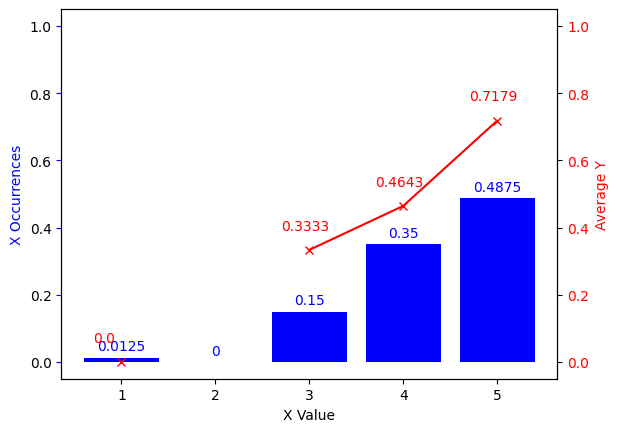

{'Y_avg': [0.0,
  nan,
  0.3333333333333333,
  0.4642857142857143,
  0.717948717948718],
 'X_num': [1, 0, 12, 28, 39],
 'X_freq': [0.0125, 0.0, 0.15, 0.35, 0.4875]}

In [12]:
show_avg_Y_and_observation(train['X1'], train['Y'])

**X2**

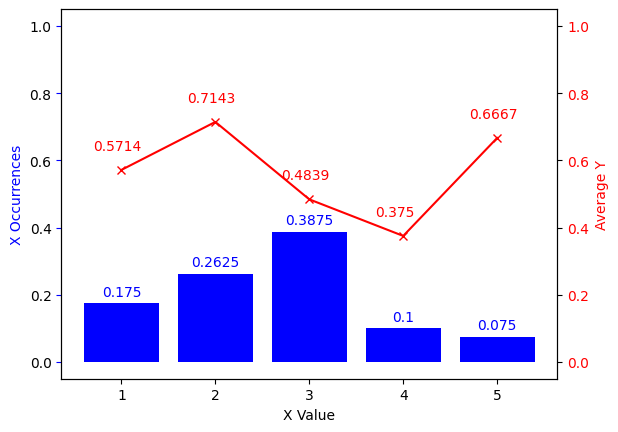

{'Y_avg': [0.5714285714285714,
  0.7142857142857143,
  0.4838709677419355,
  0.375,
  0.6666666666666666],
 'X_num': [14, 21, 31, 8, 6],
 'X_freq': [0.175, 0.2625, 0.3875, 0.1, 0.075]}

In [13]:
show_avg_Y_and_observation(train['X2'], train['Y'])

**X3**

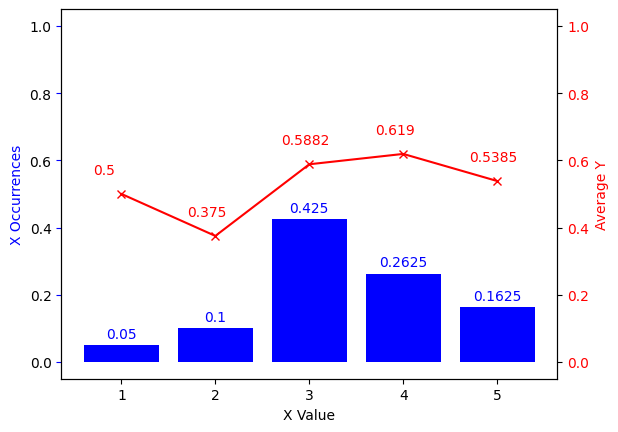

{'Y_avg': [0.5,
  0.375,
  0.5882352941176471,
  0.6190476190476191,
  0.5384615384615384],
 'X_num': [4, 8, 34, 21, 13],
 'X_freq': [0.05, 0.1, 0.425, 0.2625, 0.1625]}

In [14]:
show_avg_Y_and_observation(train['X3'], train['Y'])

**X4**

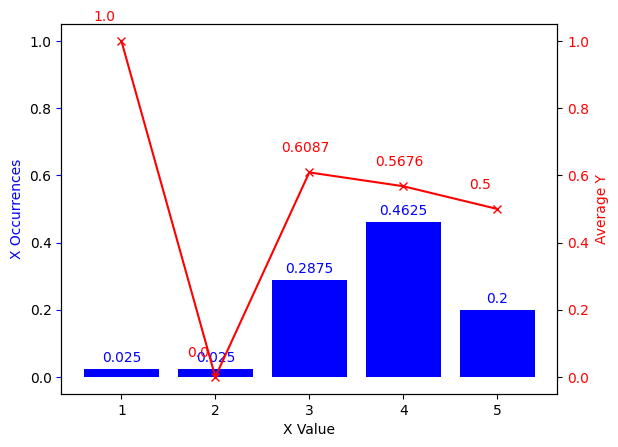

{'Y_avg': [1.0, 0.0, 0.6086956521739131, 0.5675675675675675, 0.5],
 'X_num': [2, 2, 23, 37, 16],
 'X_freq': [0.025, 0.025, 0.2875, 0.4625, 0.2]}

In [15]:
show_avg_Y_and_observation(train['X4'], train['Y'])

**X5**

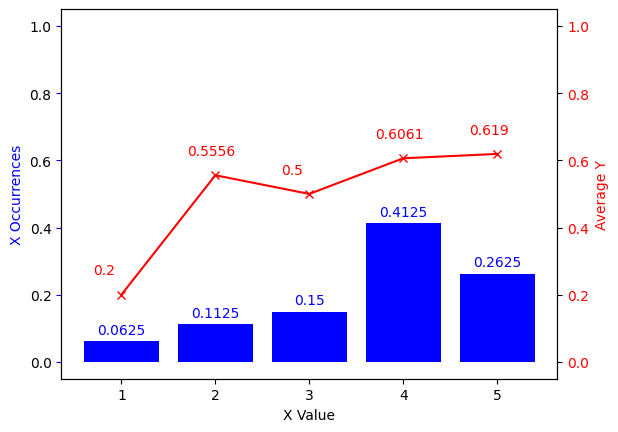

{'Y_avg': [0.2,
  0.5555555555555556,
  0.5,
  0.6060606060606061,
  0.6190476190476191],
 'X_num': [5, 9, 12, 33, 21],
 'X_freq': [0.0625, 0.1125, 0.15, 0.4125, 0.2625]}

In [16]:
show_avg_Y_and_observation(train['X5'], train['Y'])

**X6**

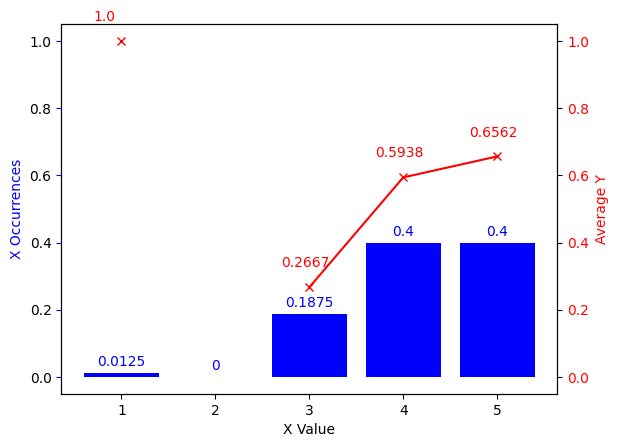

{'Y_avg': [1.0, nan, 0.26666666666666666, 0.59375, 0.65625],
 'X_num': [1, 0, 15, 32, 32],
 'X_freq': [0.0125, 0.0, 0.1875, 0.4, 0.4]}

In [17]:
show_avg_Y_and_observation(train['X6'], train['Y'])

- Probably due the small amount of data, there's no obvious sign where the change of which feature won't influence the verage of Y
- ? Maybe X2 can be deleted

## ~Standardize Data~

Not needed here, as X1~X5 are well-structured in this case.

In [18]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler().fit(X_train_un)

In [19]:
# X_train = scaler.transform(X_train_un)  ## zero mean, unit variance
# print(X_train.mean(axis=0))
# print(X_train.std(axis=0))

In [20]:
# X_val = scaler.transform(X_val_un)
# X_test = scaler.transform(X_test_un)

# print(X_val.mean(axis=0))
# print(X_val.std(axis=0))
# print(X_test.mean(axis=0))
# print(X_test.std(axis=0))

Not close to 0 and 1 --> The performance of `StandardScaler()` is **NOT** good.    
Maybe it's casued by the small data size, i.e. the distribution of training data cannot well represent the distribution of all the data.

In [21]:
## no need to change Y
# y_train, y_val, y_test = y_train_un, y_val_un, y_test_un

# XGBoost

## Train

- ! Havn't took a look at its math detail
- Not sure about the params
- Doc: use [xgboost with sklearn](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html)

In [38]:
import xgboost as xgb

clf_XGB = xgb.XGBClassifier(tree_method="hist", n_estimators = 50, early_stopping_rounds=5)
clf_XGB = clf_XGB.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print(f"training accuracy: {clf_XGB.score(X_train, y_train)}")

print(f"validation accuracy: {clf_XGB.score(X_val, y_val)}")

[0]	validation_0-logloss:0.64747
[1]	validation_0-logloss:0.64258
[2]	validation_0-logloss:0.63245
[3]	validation_0-logloss:0.64439
[4]	validation_0-logloss:0.63131
[5]	validation_0-logloss:0.63373
[6]	validation_0-logloss:0.64865
[7]	validation_0-logloss:0.66111
[8]	validation_0-logloss:0.68106
[9]	validation_0-logloss:0.67627
training accuracy: 0.7625
validation accuracy: 0.7


- The model reach its optimum performance on val set at 4th epoch. There's not much updating of the model.
- It's probably due to the small size of data. It might help if we try to reduce the model complexity in the future.

## Feature Importance

- usually by gini / entropy / info gain
- depending on the tree splitting `criteria`; the amount of impurity that was eliminated at each branch of the decision tree [[link]](https://www.codecademy.com/article/fe-feature-importance-final)
- by sklearn doc: computed as the mean and standard deviation of accumulation of the impurity decrease within each tree [[link]](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
- ! Not fully understand


**? By Gini Index:**

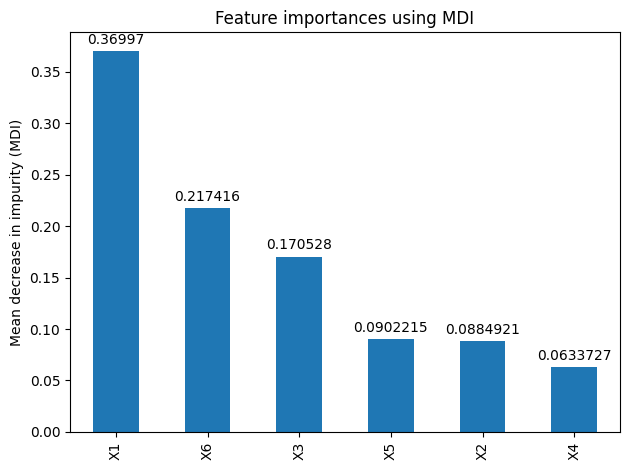

In [57]:
feature_names = X_train.columns

importances = clf_XGB.feature_importances_  ## ? using gini index by default (sklearn)
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
bar = forest_importances.plot.bar(ax=ax)
ax.bar_label(bar.containers[0], padding=3)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity (MDI)")
fig.tight_layout()

**By Info Gain:** [[Link]](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

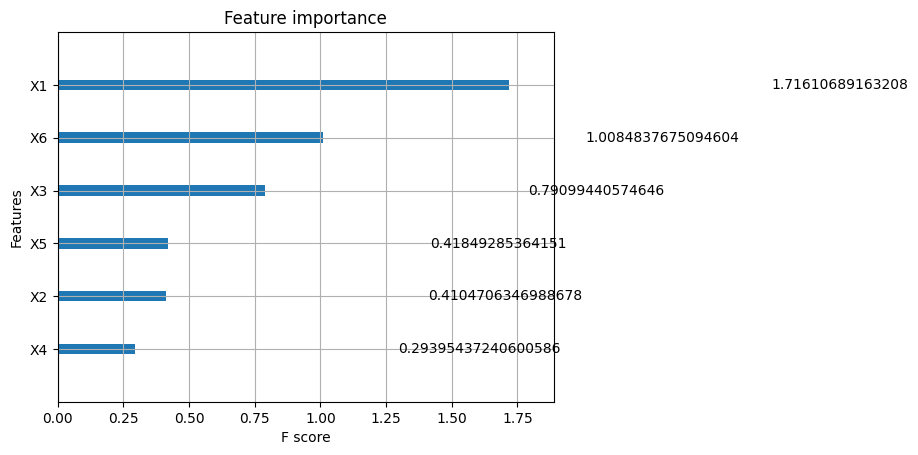

In [46]:
from xgboost import plot_importance

plot_importance(clf_XGB, importance_type='gain')  ## using info gain
plt.show()

- X4 and X2 may be deleted as they are the least important

## Confusion Matrix

In [59]:
y_val_ = clf_XGB.predict(X_val)
y_train_ = clf_XGB.predict(X_train)

In [60]:
val['Y_'] = y_val_
train['Y_'] = y_train_

Confusion_Matrix
Training:---------


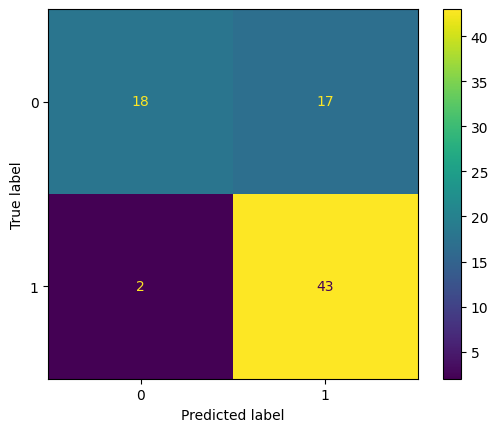

Validation:---------


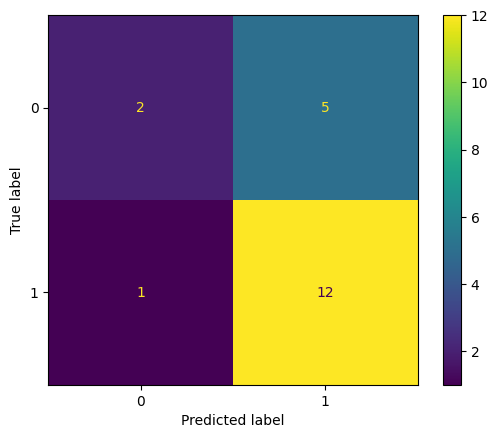

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
## Confusion matrix whose i-th row and j-th column entry
## indicates the number of samples with
## true label being i-th class and predicted label being j-th class.
## row -- true label; col -- pred label

print("Confusion_Matrix")
label = [0, 1]
print("Training:---------")
cm_train = confusion_matrix(y_train, y_train_, labels=label)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label)
disp_train.plot()
plt.show()

print("Validation:---------")
cm_val = confusion_matrix(y_val, y_val_, labels=[0,1])
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label)
disp_val.plot()
plt.show()

- Samples with true label `Y = 0` are easily being predicted as `Y_ = 1`

## ROC curve

On Training Set


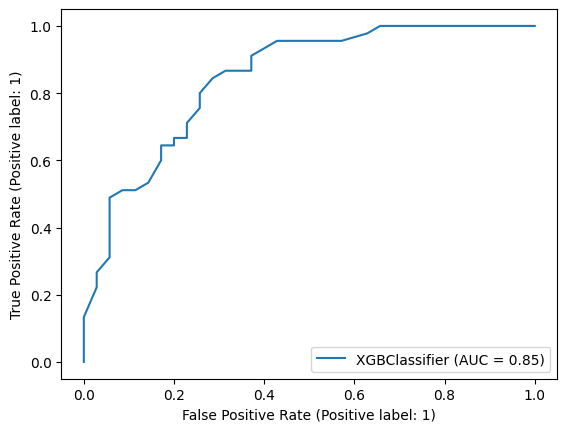

In [ ]:
from sklearn.metrics import RocCurveDisplay

print("On Training Set")
RocCurveDisplay.from_estimator(clf_XGB, X_train, y_train)

On Validation Set: --------------


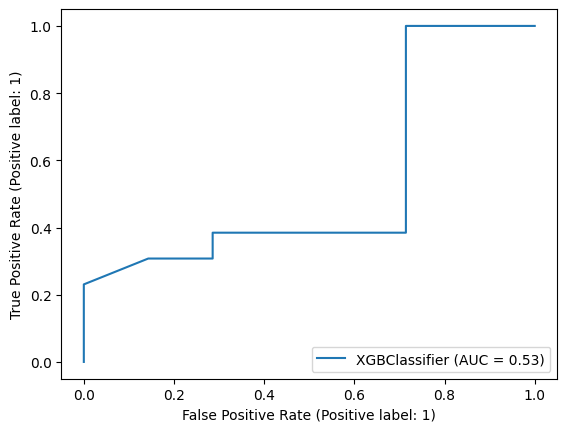

In [ ]:
print("On Validation Set: --------------")
RocCurveDisplay.from_estimator(clf_XGB, X_val, y_val)

## Column Inspection - train vs val

In [ ]:
def show_train_val_avg_Y_and_X_occr(X1, Y1, X2, Y2, X_value=[1,2,3,4,5], \
                                    show_plot=True, \
                                    Colors = ['Blue', 'Red', 'Green', 'Orange'], \
                                    Labels=['train X Occur', 'train Y Avg', 'val X Occur', 'val pred Y avg'], \
                                    ):
  """
  Input should be dataframe columns
  """
  X_value = np.array(X_value)

  info_1 = show_avg_Y_and_observation(X1, Y1, X_value=X_value, show_plot=False)
  info_2 = show_avg_Y_and_observation(X2, Y2,  X_value=X_value, show_plot=False)

  X1_num = info_1['X_num']
  X2_num = info_2['X_num']
  Y1_avg = info_1['Y_avg']
  Y2_avg = info_2['Y_avg']

  if show_plot:
    fig, ax1 = plt.subplots()

    ## plot X occurrences
    ax1.set_xlabel('X Value')
    ax1.set_ylabel('X Occurrences')
    width = 0.25

    bar1 = ax1.bar(X_value-0.5*width, X1_num, width, label=Labels[0], color=Colors[0])
    ax1.bar_label(bar1, padding=3, color=Colors[0])

    bar2 = ax1.bar(X_value+0.5*width, X2_num, width, label=Labels[2], color=Colors[2])
    ax1.bar_label(bar2, padding=3, color=Colors[2])

    ax1.tick_params(axis='y')
    # ax1.legend()

    ## plot Y average
    ax2 = ax1.twinx()  # share the x-axis, new y-axis
    ax2.set_ylabel('Average Y')

    line1 = ax2.plot(X_value-0.5*width, Y1_avg, marker="x", label=Labels[1], color=Colors[1])
    for i, j in zip(X_value, Y1_avg):
      j = round(j, 4)
      plt.text(i-2*width, j+0.04, str(j), color=Colors[1])

    line2 = ax2.plot(X_value+0.5*width, Y2_avg, marker="x", label=Labels[3], color=Colors[3])
    for i, j in zip(X_value, Y2_avg):
      j = round(j, 4)
      plt.text(i+0.5*width, j+0.02, str(j), color=Colors[3])

    ax2.tick_params(axis='y')
    ax2.set_ylim(-0.05, 1.05)

    ## Add legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(-0.1,1.02,1,0.2), loc="lower left",ncol=4)

    plt.show()

  return {"info_1": info_1, "info_2": info_2}

# show_train_val_avg_Y_and_X_occr(train['X1'], train['Y'], val['X1'], val['Y_'])

**Below we will use true label in training set and predicted label in validation set**

**X1**

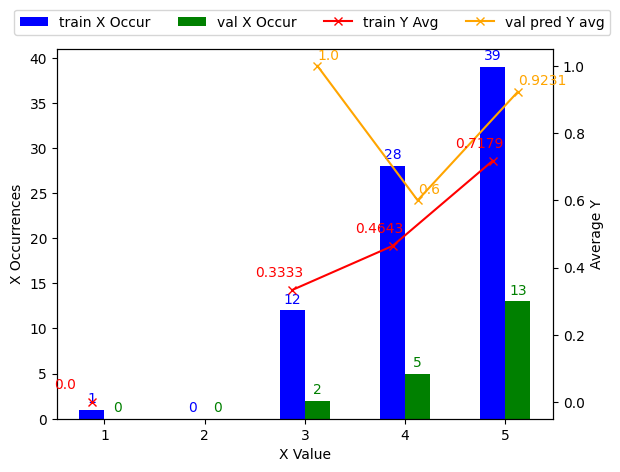

{'info_1': {'Y_avg': [0.0,
   nan,
   0.3333333333333333,
   0.4642857142857143,
   0.717948717948718],
  'X_num': [1, 0, 12, 28, 39],
  'X_freq': [0.0125, 0.0, 0.15, 0.35, 0.4875]},
 'info_2': {'Y_avg': [nan, nan, 1.0, 0.6, 0.9230769230769231],
  'X_num': [0, 0, 2, 5, 13],
  'X_freq': [0.0, 0.0, 0.1, 0.25, 0.65]}}

In [ ]:
show_train_val_avg_Y_and_X_occr(train['X1'], train['Y'], val['X1'], val['Y_'])

**X2**

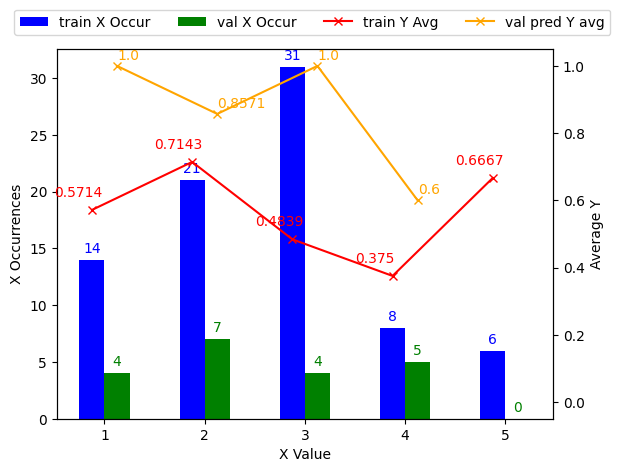

{'info_1': {'Y_avg': [0.5714285714285714,
   0.7142857142857143,
   0.4838709677419355,
   0.375,
   0.6666666666666666],
  'X_num': [14, 21, 31, 8, 6],
  'X_freq': [0.175, 0.2625, 0.3875, 0.1, 0.075]},
 'info_2': {'Y_avg': [1.0, 0.8571428571428571, 1.0, 0.6, nan],
  'X_num': [4, 7, 4, 5, 0],
  'X_freq': [0.2, 0.35, 0.2, 0.25, 0.0]}}

In [ ]:
show_train_val_avg_Y_and_X_occr(train['X2'], train['Y'], val['X2'], val['Y_'])

**X3**

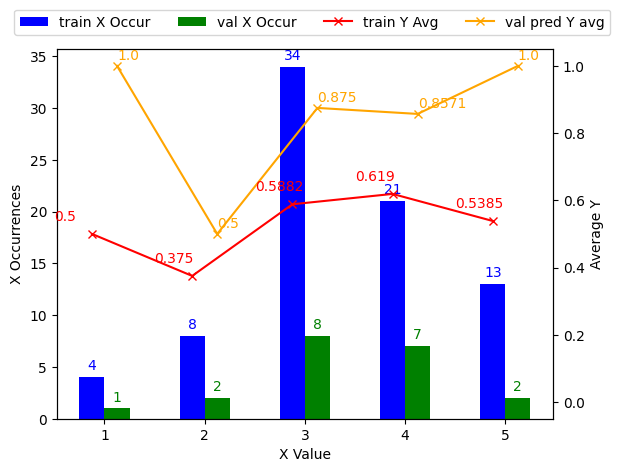

{'info_1': {'Y_avg': [0.5,
   0.375,
   0.5882352941176471,
   0.6190476190476191,
   0.5384615384615384],
  'X_num': [4, 8, 34, 21, 13],
  'X_freq': [0.05, 0.1, 0.425, 0.2625, 0.1625]},
 'info_2': {'Y_avg': [1.0, 0.5, 0.875, 0.8571428571428571, 1.0],
  'X_num': [1, 2, 8, 7, 2],
  'X_freq': [0.05, 0.1, 0.4, 0.35, 0.1]}}

In [ ]:
show_train_val_avg_Y_and_X_occr(train['X3'], train['Y'], val['X3'], val['Y_'])

**X4**

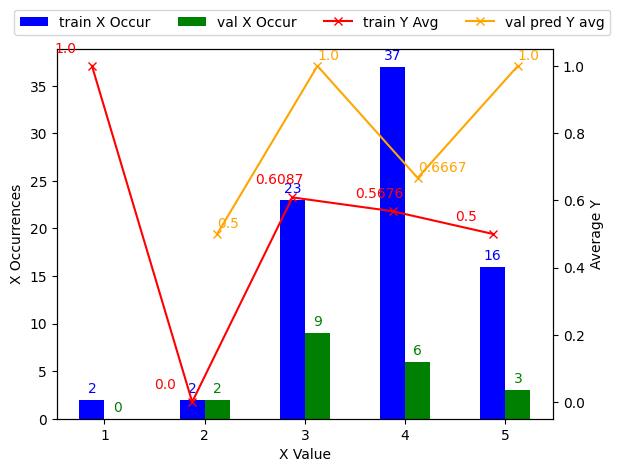

{'info_1': {'Y_avg': [1.0, 0.0, 0.6086956521739131, 0.5675675675675675, 0.5],
  'X_num': [2, 2, 23, 37, 16],
  'X_freq': [0.025, 0.025, 0.2875, 0.4625, 0.2]},
 'info_2': {'Y_avg': [nan, 0.5, 1.0, 0.6666666666666666, 1.0],
  'X_num': [0, 2, 9, 6, 3],
  'X_freq': [0.0, 0.1, 0.45, 0.3, 0.15]}}

In [ ]:
show_train_val_avg_Y_and_X_occr(train['X4'], train['Y'], val['X4'], val['Y_'])

**X5**

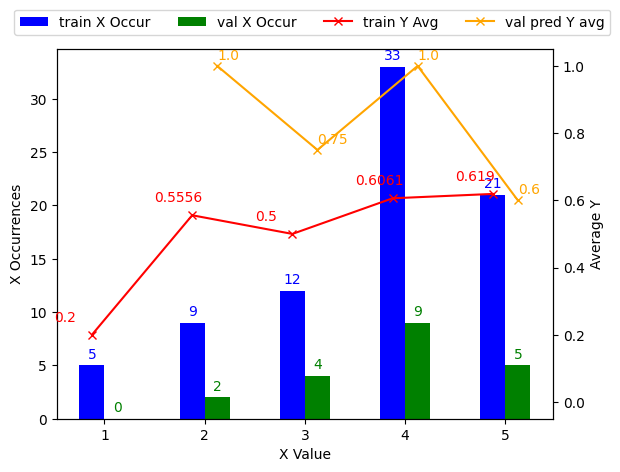

{'info_1': {'Y_avg': [0.2,
   0.5555555555555556,
   0.5,
   0.6060606060606061,
   0.6190476190476191],
  'X_num': [5, 9, 12, 33, 21],
  'X_freq': [0.0625, 0.1125, 0.15, 0.4125, 0.2625]},
 'info_2': {'Y_avg': [nan, 1.0, 0.75, 1.0, 0.6],
  'X_num': [0, 2, 4, 9, 5],
  'X_freq': [0.0, 0.1, 0.2, 0.45, 0.25]}}

In [ ]:
show_train_val_avg_Y_and_X_occr(train['X5'], train['Y'], val['X5'], val['Y_'])

**X6**

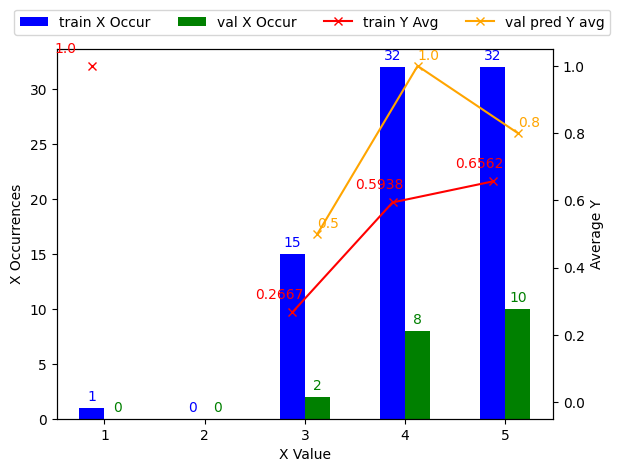

{'info_1': {'Y_avg': [1.0, nan, 0.26666666666666666, 0.59375, 0.65625],
  'X_num': [1, 0, 15, 32, 32],
  'X_freq': [0.0125, 0.0, 0.1875, 0.4, 0.4]},
 'info_2': {'Y_avg': [nan, nan, 0.5, 1.0, 0.8],
  'X_num': [0, 0, 2, 8, 10],
  'X_freq': [0.0, 0.0, 0.1, 0.4, 0.5]}}

In [ ]:
show_train_val_avg_Y_and_X_occr(train['X6'], train['Y'], val['X6'], val['Y_'])

# Exclude X4

In [31]:
## drop X4
X_train_2 = X_train.drop(columns=['X4'])
X_val_2 = X_val.drop(columns=['X4'])
X_test_2 = X_test.drop(columns=['X4'])

In [34]:
clf_XGB2 = xgb.XGBClassifier(tree_method="hist", n_estimator=50, early_stopping_rounds=5)
clf_XGB2.fit(X_train_2, y_train, eval_set=[(X_val_2, y_val)])
print(f"training accuracy: {clf_XGB2.score(X_train_2, y_train)}")

print(f"validation accuracy: {clf_XGB2.score(X_val_2, y_val)}")

[0]	validation_0-logloss:0.64747
[1]	validation_0-logloss:0.64452
[2]	validation_0-logloss:0.65064
[3]	validation_0-logloss:0.65362
[4]	validation_0-logloss:0.64669
[5]	validation_0-logloss:0.63866
[6]	validation_0-logloss:0.64874
[7]	validation_0-logloss:0.66123
[8]	validation_0-logloss:0.66722
[9]	validation_0-logloss:0.67101
training accuracy: 0.7875
validation accuracy: 0.7


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:23:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


On Validation Set: --------------


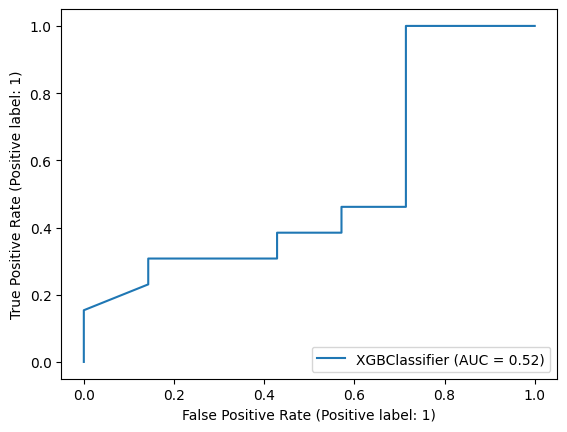

In [ ]:
print("On Validation Set: --------------")
RocCurveDisplay.from_estimator(clf_XGB2, X_val_2, y_val)

# Test Set

In [35]:
print(f"model 1 test accuracy: {clf_XGB.score(X_test, y_test)}")
print(f"model 2 test accuracy: {clf_XGB2.score(X_test_2, y_test)}")

model 1 test accuracy: 0.46153846153846156
model 2 test accuracy: 0.5384615384615384


https://www.w3schools.com/python/python_ml_confusion_matrix.asp

classification report